### 라이브러리 로드 및 데이터 경로 설정  
### Import required libraries and define the data file path

###  엑셀 파일의 시트 구조 확인  
###  Inspect available sheet names in the GTD Excel file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = "data/raw/GTD/globalterrorismdb_0522dist.xlsx"


### 분석에 필요한 핵심 변수만 불러오기  
### Load only the essential variables required for analysis


In [2]:
SHEET_NAME = "Data"  # 안 되면 xl.sheet_names[0] 로 바꾸기

usecols = [
    "eventid","iyear","imonth","iday",
    "country_txt","region_txt","provstate","city",
    "latitude","longitude",
    "attacktype1_txt","weaptype1_txt","targtype1_txt",
    "gname",
    "nkill","nwound",
    "doubtterr","success"
]

df = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME, usecols=usecols, engine="openpyxl")
df.shape, df.head(3)


((209706, 18),
         eventid  iyear  imonth  iday         country_txt  \
 0  197000000001   1970       7     2  Dominican Republic   
 1  197000000002   1970       0     0              Mexico   
 2  197001000001   1970       1     0         Philippines   
 
                     region_txt provstate           city   latitude  \
 0  Central America & Caribbean  National  Santo Domingo  18.456792   
 1                North America   Federal    Mexico city  19.371887   
 2               Southeast Asia    Tarlac        Unknown  15.478598   
 
     longitude  doubtterr  success              attacktype1_txt  \
 0  -69.951164          0        1                Assassination   
 1  -99.086624          0        1  Hostage Taking (Kidnapping)   
 2  120.599741          0        1                Assassination   
 
                  targtype1_txt                               gname  \
 0  Private Citizens & Property                              MANO-D   
 1      Government (Diplomatic)  23rd of 

#### File loading test (if uploading didn't work!)

In [3]:
# 행 수 제한해서 테스트
# df_test = pd.read_excel(
#     DATA_PATH,
#     sheet_name=SHEET_NAME,
#     nrows=10000
# )
# df_test.shape


### 분석 기간 제한 및 기본 데이터 전처리  
### Filter the analysis period and perform basic data preprocessing


In [4]:
import numpy as np
import pandas as pd

# (오늘 제출용) 2000~2021로 제한: 시각화/SQL/모델링 다 깔끔해짐
df = df[(df["iyear"] >= 2000) & (df["iyear"] <= 2021)].copy()

# imonth, iday 0 처리(날짜 생성용)
df["imonth"] = df["imonth"].fillna(1).replace(0, 1)
df["iday"] = df["iday"].fillna(1).replace(0, 1)

# 숫자형 변환 + 결측 처리
for c in ["nkill", "nwound", "latitude", "longitude"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["nkill"] = df["nkill"].fillna(0)
df["nwound"] = df["nwound"].fillna(0)
df["casualty"] = df["nkill"] + df["nwound"]

# 날짜 컬럼 생성
df["date"] = pd.to_datetime(
    dict(year=df["iyear"], month=df["imonth"], day=df["iday"]),
    errors="coerce"
)

df.shape, df[["iyear","country_txt","region_txt","nkill","nwound","casualty"]].head()


((139872, 20),
        iyear country_txt          region_txt  nkill  nwound  casualty
 69833   2000     Namibia  Sub-Saharan Africa    0.0     7.0       7.0
 69834   2000     Namibia  Sub-Saharan Africa    0.0     7.0       7.0
 69835   2000       India          South Asia    1.0     2.0       3.0
 69836   2000      Kosovo      Eastern Europe    0.0     1.0       1.0
 69837   2000     Somalia  Sub-Saharan Africa    6.0    10.0      16.0)

### 전처리된 데이터 저장  
### Save the cleaned dataset for reuse in subsequent analyses

In [5]:
import os
os.makedirs("data/interim", exist_ok=True)

df.to_parquet("data/interim/gtd_clean.parquet", index=False)
print("saved:", "data/interim/gtd_clean.parquet", df.shape)


saved: data/interim/gtd_clean.parquet (139872, 20)


### 연도별 전 세계 테러 발생 추이  
### Global trend of terrorist attacks by year


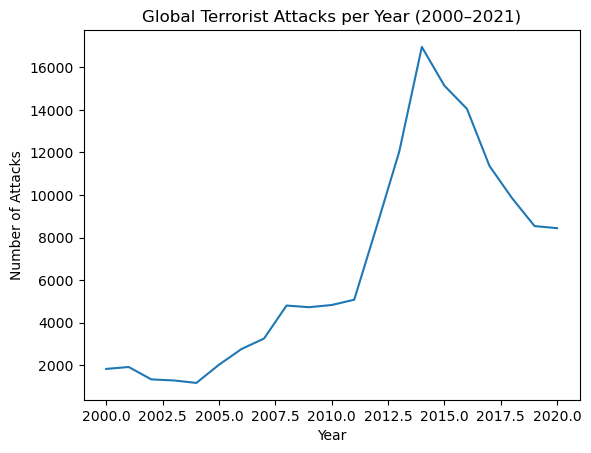

In [6]:
import matplotlib.pyplot as plt

yearly_attacks = df.groupby("iyear").size()

plt.figure()
yearly_attacks.plot()
plt.title("Global Terrorist Attacks per Year (2000–2021)")
plt.xlabel("Year")
plt.ylabel("Number of Attacks")
plt.show()


### 연도별 테러로 인한 사망자 수 변화  
### Annual trend in terrorism-related fatalities


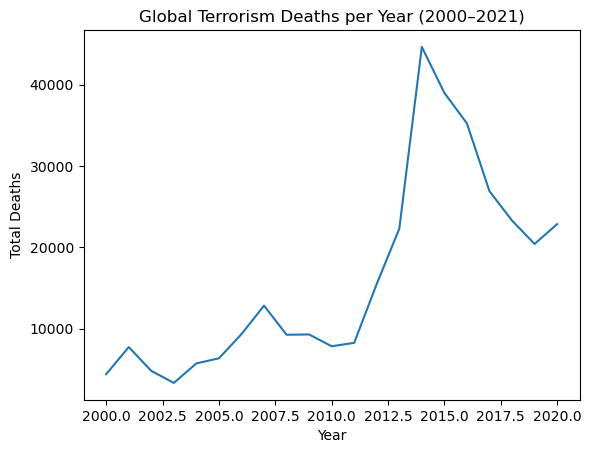

In [7]:
yearly_deaths = df.groupby("iyear")["nkill"].sum()

plt.figure()
yearly_deaths.plot()
plt.title("Global Terrorism Deaths per Year (2000–2021)")
plt.xlabel("Year")
plt.ylabel("Total Deaths")
plt.show()


### 지역별 테러 발생 건수 상위 분포  
### Top regions by number of terrorist incidents


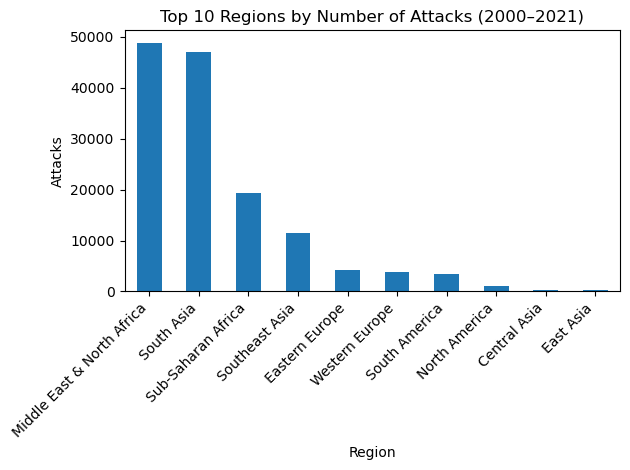

In [8]:
region_top = df["region_txt"].value_counts().head(10)

plt.figure()
region_top.plot(kind="bar")
plt.title("Top 10 Regions by Number of Attacks (2000–2021)")
plt.xlabel("Region")
plt.ylabel("Attacks")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 주요 테러 공격 유형 분포  
### Distribution of major attack types in terrorism incidents


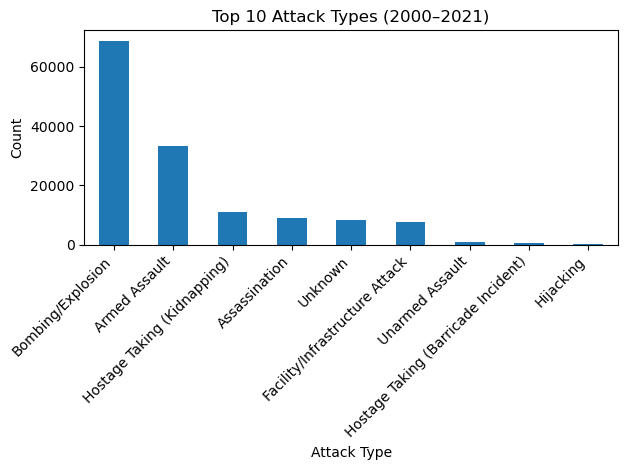

In [9]:
attack_top = df["attacktype1_txt"].value_counts().head(10)

plt.figure()
attack_top.plot(kind="bar")
plt.title("Top 10 Attack Types (2000–2021)")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 전처리된 데이터 저장  
### Save the cleaned dataset for reuse in subsequent analyses
